This notebook has all of the numbers and plots I used in the writeup. I tried to keep it reasonably organized but I was also a bit lazy, so some code might be sloppy hard to follow... sorry.

# load libraries and data

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googleapiclient import discovery
import utils
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import pickle

In [2]:
guest_df = utils.load_guest_list_file(apply_filters=True)

In [3]:
# vader sentiment analyzer
sia = SentimentIntensityAnalyzer()

# perspective API
api_key = open(utils.perspective_api_key_file).read().split()[0]
api = discovery.build('commentanalyzer', 'v1alpha1', developerKey=api_key)

I'm going to use R for some visualizations because ggplot kicks matplotlib's butt.

In [4]:
%load_ext rpy2.ipython
# install R packages with conda: conda install -c r r-ggplot2

In [5]:
%%capture
%%R

library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)

df <- read_csv("./guest_list.csv") %>%
    # these same filters are applied to the pandas dataframe
    filter(!is.na(video_id),
           guest != "holiday special",
           guest != "Stephen Colbert")

df$season <- factor(df$season)
df$female_flag <- factor(df$female_flag)

# Chrissy Teigen examples

In [6]:
# load comments file
video_id = guest_df.loc[guest_df['guest'] == 'Chrissy Teigen', 'video_id'].values[0]
comment_file = os.path.join(utils.comment_dir, f'comments-{video_id}.json')
comments = [c['commentText'] for c in json.load(open(comment_file, 'r')) if 'commentText' in c]

In [7]:
def get_scores(text):
    sent = sia.polarity_scores(text)['compound']
    
    analyze_request = {
        'comment': {'text': text},
        'requestedAttributes': {'TOXICITY': {}, 'SEVERE_TOXICITY': {}},
        'languages': ['en']
    }
    
    response = api.comments().analyze(body=analyze_request).execute()
    tox_score = response['attributeScores']['TOXICITY']['summaryScore']['value']
    sev_tox_score = response['attributeScores']['SEVERE_TOXICITY']['summaryScore']['value']
    
    out = f'\nsentiment score: {sent}'
    out += f'\ntoxicity:        {tox_score}'
    out += f'\nsevere toxicity: {sev_tox_score}'
    
    return out

In [8]:
c1 = comments[2288]
print(c1)
print(get_scores(c1))

PLEASE DON'T EVER BRING A DISGUSTING UGLY SACK OF SHIT ON THIS SHOW AGAIN! WHY WOULD YOU BRING THAT CHIPMUNK LOOKING ASS BITCH ON HERE? SHE IS SO ANNOYING HER FACE IS HIDEOUS, HER VOICE IS HORRENDOUS, I PERSONALLY DON'T EVEN KNOW WHY SHE'S FAMOUS ASIDE FROM BEING MARRIED TO JL. I WISH THIS BITCH WOULD FUCKING DIE YOU UGLY FUCKING CUNT! YOU ARE EXTREMELY DISGUSTING YOU FUCKING FAT HEADED SLUT WHORE BITCH CUNT! DIE DIE DIE DIE DIE DIE DIE

sentiment score: -0.9974
toxicity:        0.95688325
severe toxicity: 0.95164716


In [9]:
c2 = comments[232]
print(c2)
print(get_scores(c2))

Chrissy is hands down a savage!! She killed it!! Its way worse to just lick the sauce

sentiment score: -0.9147
toxicity:        0.7247795
severe toxicity: 0.6323825


In [10]:
c3 = comments[6042]
print(c3)
print(get_scores(c3))

Hell nooo eat the DAM wing. You knew you were going to Hot Ones. What. waste of wing.  SHAME Delete a the episode. Retake of season 7 episode 1 SMH.

sentiment score: -0.9356
toxicity:        0.76644164
severe toxicity: 0.5029349


# sentiment analysis

I'm using a metric that I'm calling positive ratio, defined as 

$$ positive\_ratio = \frac{\text{# of positive comments}}{\text{# of negative comments}} $$

where positive comments have sentiment scores greater than 0 and negative comments have scores less than 0. As an example, a video with twice as many positive comments as negative would have a positive ratio of 2.

The benefit to using positive ratio is that it removes the effect of neutral comments. Many comments in the dataset have sentiment scores of exactly 0, and all of those 0 values can dilute a metric like average sentiment score.

The downside to using positive ratio is that it ignores the magnitude of sentiment scores. For example, a comment with sentiment score 0.1 has the same effect on positive ratio as a comment with sentiment score 0.9.

Due to the large number of neutral comments, I decided that positive ratio was the most appropriate metric for this dataset. In any case, the results are pretty similar with any metric.

/Users/Daniel/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 9.72 x 4.86 in image

  warnings.warn(x, RRuntimeWarning)


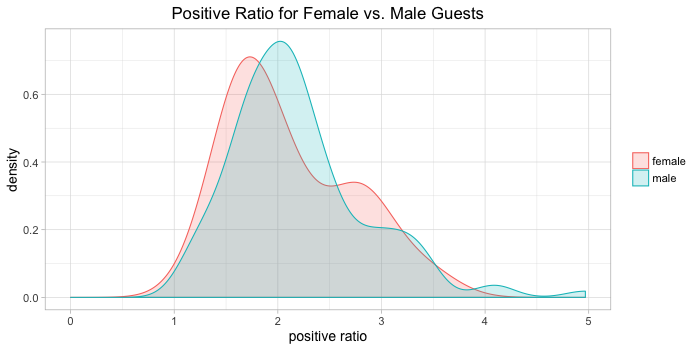

In [11]:
%%R -w 700 -h 350

p <- df %>%
  mutate(female_flag = if_else(female_flag == 0, ' male', ' female')) %>%
  filter(season != 1) %>% 
  ggplot() +
  geom_density(aes(x=positive_ratio, color=female_flag, fill=female_flag), alpha=0.2) +
  labs(title="Positive Ratio for Female vs. Male Guests", x="positive ratio") +
  expand_limits(x=0) +
  theme_light(base_size=14) +
  theme(plot.title=element_text(hjust = 0.5), legend.title=element_blank())

ggsave(filename='./visualizations/positive_ratio_by_male_female.png', plot=p)

p

In [12]:
df = guest_df[guest_df['season'] != 1]
f_vals = df[df['female_flag'] == 1]['positive_ratio']
m_vals = df[df['female_flag'] == 0]['positive_ratio']

print(f'female guest positive ratio: {round(f_vals.mean(), 3)}')
print(f'male guest positive ratio  : {round(m_vals.mean(), 3)}')

female guest positive ratio: 2.115
male guest positive ratio  : 2.198


In [13]:
ttest_ind(m_vals, f_vals)

Ttest_indResult(statistic=0.5586532931619845, pvalue=0.5773103191862539)

# toxicity scores

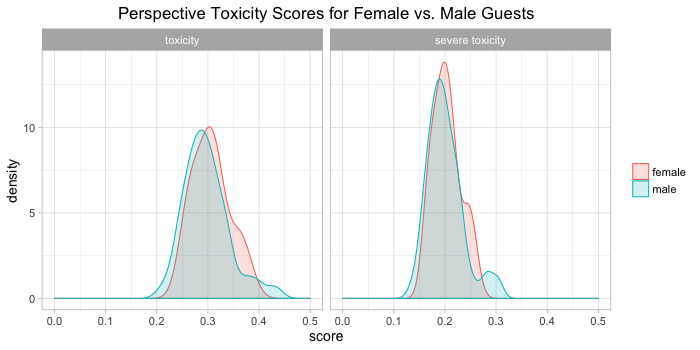

In [14]:
%%R -w 700 -h 350

p <- df %>% 
  mutate(female_flag = if_else(female_flag == 0, ' male', ' female')) %>%
  filter(season != 1) %>% 
  rename(toxicity = mean_toxicity,
         `severe toxicity` = mean_severe_toxicity) %>% 
  gather("metric", "value", c("toxicity", "severe toxicity")) %>% 
  mutate(metric = factor(metric, levels=c("toxicity", "severe toxicity"))) %>% 
  ggplot() +
  geom_density(aes(x=value, color=female_flag, fill=female_flag), alpha=0.2) +
  labs(title="Perspective Toxicity Scores for Female vs. Male Guests", x="score") +
  expand_limits(x=0) +
  expand_limits(x=0.5) +
  facet_grid(. ~ metric) +
  theme_light(base_size=14) +
  theme(plot.title=element_text(hjust = 0.5), legend.title=element_blank())

ggsave(filename='./visualizations/toxicity_scores_by_male_female.png', plot=p)

p

In [15]:
df = guest_df[guest_df['season'] != 1]
f_tox = df[df['female_flag'] == 1]['mean_toxicity']
m_tox = df[df['female_flag'] == 0]['mean_toxicity']
f_sev_tox = df[df['female_flag'] == 1]['mean_severe_toxicity']
m_sev_tox = df[df['female_flag'] == 0]['mean_severe_toxicity']

print(f'female guest average toxicity: {round(f_tox.mean(), 3)}')
print(f'male guest average toxicity  : {round(m_tox.mean(), 3)}')
print(f'female guest average severe toxicity: {round(f_sev_tox.mean(), 3)}')
print(f'male guest average severe toxicity  : {round(m_sev_tox.mean(), 3)}')

female guest average toxicity: 0.306
male guest average toxicity  : 0.297
female guest average severe toxicity: 0.204
male guest average severe toxicity  : 0.2


In [16]:
ttest_ind(m_tox, f_tox)

Ttest_indResult(statistic=-0.9200858769136752, pvalue=0.3591451265358795)

In [17]:
ttest_ind(m_sev_tox, f_sev_tox)

Ttest_indResult(statistic=-0.4022602047447655, pvalue=0.6881194552463817)

### why exclude season 1 from sentiment analysis?

Far lower average sentiment score than later seasons. Show was still finding its stride and had some structural and aesthetic differences from later seasons. Some major outliers (especially the infamous DJ Khaled episode).

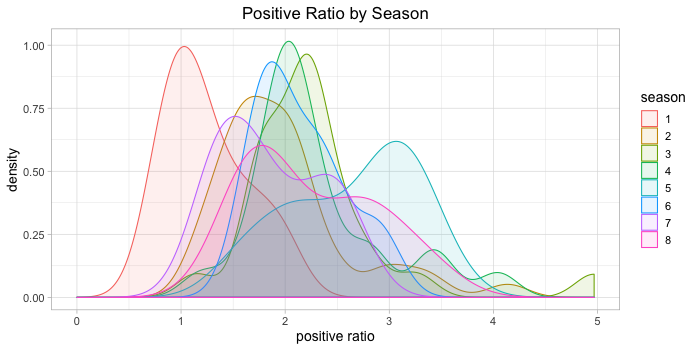

In [18]:
%%R -w 700 -h 350

p <- df %>% 
  ggplot() +
  geom_density(aes(x=positive_ratio, color=season, fill=season), alpha=0.1) +
  labs(title="Positive Ratio by Season", x="positive ratio") +
  expand_limits(x=0) +
  theme_light(base_size=14) +
  theme(plot.title=element_text(hjust = 0.5))

ggsave(filename='./visualizations/positive_ratio_by_season.png', plot=p)

p

# word usage

In [19]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

In [20]:
word_df = pickle.load(open('./data/gender_analysis_bigram.pickle', 'rb'))

In [21]:
f_top_100 = word_df[['token', 'z_score']].rename(columns={'token': 'female'}).head(100)
m_top_100 = word_df[['token', 'z_score']].rename(columns={'token': 'male'}).sort_index(ascending=False).reset_index(drop=True).head(100)
f_top_100.join(m_top_100, lsuffix='_f', rsuffix='_m')

,female,z_score_f,male,z_score_m
0,<pronoun>,-128.307584,<name>,93.577055
1,woman,-84.465056,shit,67.809982
2,girl,-74.403413,guy,59.228995
3,<pronoun> be,-74.335764,fuck,48.349722
4,vegan,-63.756657,dude,45.994477
5,beautiful,-62.440556,hell,44.264971
6,love <pronoun>,-59.197134,<name> <name>,43.392711
7,😍,-58.026002,man,42.945815
8,<pronoun> so,-50.016143,this guy,42.334026
9,<pronoun> s,-46.634058,best,41.676481
